# Load county and chip to lat/lon mapping

In [1]:
import pandas as pd

county_lonlat = pd.read_csv("county_lonlat_map.csv")
print ("Head of county_lonlat\n", county_lonlat.head())

all_county_longlat = {
    County: (Longitude, Latitude)
    for County, Longitude, Latitude in 
    zip(county_lonlat["CountyName"], county_lonlat["Longitude"], county_lonlat["Latitude"])
}

Head of county_lonlat
            CountyName   Latitude  Longitude
0     COFFEE, ALABAMA  31.402630 -85.988210
1    COLBERT, ALABAMA  32.280036 -85.237594
2    CULLMAN, ALABAMA  34.173790 -86.843012
3    JACKSON, ALABAMA  31.520672 -87.895819
4  JEFFERSON, ALABAMA  33.574594 -86.874093


In [2]:
chip_lonlat = pd.read_csv("chip_lonlat_map.csv")
print ("Head of chip_lonlat\n", chip_lonlat.head())

import pickle
chip_lonlat = pickle.load(open("chip_lonlat_map.pkl", "rb")) 

Head of chip_lonlat
            chip                                   topleft  \
0  chip_257_266  (-102.35983111053801, 35.89100745138819)   
1  chip_328_501  (-85.32661747065502, 31.280173278425647)   
2  chip_171_477  (-85.82884960564373, 40.812461946029586)   
3  chip_236_281     (-101.3232211450471, 37.203690843181)   
4  chip_134_482   (-85.08944085278173, 42.98820474855942)   

                                 bottomright  
0   (-102.27956787008041, 35.83486329580573)  
1   (-85.26395231465536, 31.213070890689277)  
2    (-85.75731755057087, 40.74607675535047)  
3  (-101.24233097267351, 37.146893620710294)  
4    (-85.01636707701203, 42.92124090258859)  


# Match chip to county based on lat/lon

In [3]:
import tqdm

def is_point_in_rectangle(top_left, bottom_right, point):
    lon1, lat1 = top_left
    lon2, lat2 = bottom_right
    lon, lat = point

    # value error: top-left must be less than bottom-right
    if lon1 >= lon2 or lat1 <= lat2:
        raise ValueError("Invalid rectangle coordinates: top-left must be less than bottom-right")

    # check if point is in rectangle
    return lon1 <= lon <= lon2 and lat2 <= lat <= lat1

def longlat_diff(top_left, bottom_right, point):
    lon1, lat1 = top_left
    lon2, lat2 = bottom_right
    lon, lat = point
    avg_lon = (lon1 + lon2) / 2
    avg_lat = (lat1 + lat2) / 2
    lon_diff, lat_diff = abs(lon - avg_lon), abs(lat - avg_lat)
    # diff = max(lon_diff, lat_diff)
    diff = (lon_diff + lat_diff) / 2
    return diff, lon_diff, lat_diff

def inverse_dict(d):
    inv_d = {}
    for key, value in d.items():
        if value not in inv_d:
            inv_d[value] = []
        inv_d[value].append(key)
    return inv_d


# LIMIT = 0.25
# LIMIT = 0.5
LIMIT = 1
chip_county_map = {}

 
iterator = tqdm.tqdm(chip_lonlat.keys())
iterator.set_description("Mapping chips to counties")

for chip in iterator:
    top_left, bottom_right = chip_lonlat[chip]
    dist_to_county = []
    for county, county_lonlat in all_county_longlat.items():
        diff, lon_diff, lat_diff = longlat_diff(top_left, bottom_right, county_lonlat)
        dist_to_county.append((county, diff, lon_diff, lat_diff))
    dist_to_county.sort(key=lambda x: x[1])
    # if the closest county is within RELAX distance, assign the chip to the county
    if dist_to_county[0][1] <= LIMIT:
        chip_county_map[chip] = dist_to_county[0][0]
    # else:
    #     print(f"Chip {chip} is not in any county")
    # break

county_chip_map = inverse_dict(chip_county_map)

print (f"{len(county_chip_map)}/{len(all_county_longlat)} counties mapped to {len(chip_county_map)} chips")
pd.DataFrame(zip(chip_county_map.keys(), chip_county_map.values()), columns=["chip", "county"]).to_csv(
    f"chip_county_map_limit{LIMIT}_{len(chip_county_map)}chip_{len(county_chip_map)}cnty.csv", index=False
)
print (f"Saved chip_county map to chip_county_map_limit{LIMIT}.csv")

# chip_county_map
# county_chip_map

Mapping chips to counties: 100%|██████████| 3854/3854 [00:00<00:00, 7313.23it/s]

168/261 counties mapped to 3138 chips
Saved chip_county map to chip_county_map_limit1.csv


## Train/Test Split

c:\Users\ZhiningLiu\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ZhiningLiu\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='num_chips', ylabel='Count'>

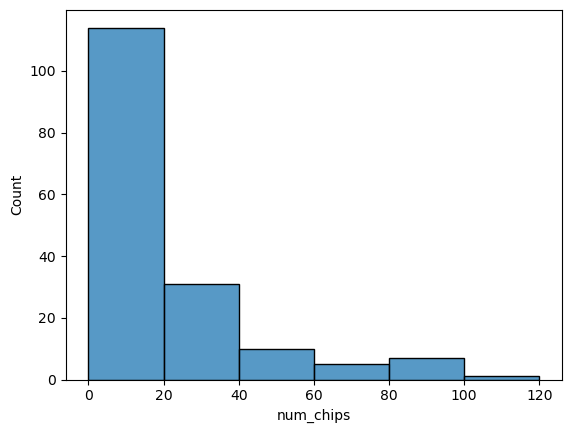

In [4]:
county_chip_num = {county: len(chips) for county, chips in county_chip_map.items()}
county_chip_num = pd.DataFrame(zip(county_chip_num.keys(), county_chip_num.values()), columns=["county", "num_chips"])

import seaborn as sns
sns.histplot(county_chip_num["num_chips"], bins=6, binrange=(0, 120))

In [5]:
import numpy as np

test_ratio = 0.2

county_hist_labels = []
for county in county_chip_num['county'].values:
    county_hist_label = county_chip_num.loc[county_chip_num['county'] == county, 'num_chips'].values[0] // 20
    if county_hist_label > 4:
        county_hist_label = 4
    county_hist_labels.append(county_hist_label)
county_hist_labels = np.array(county_hist_labels)

np.unique(county_hist_labels, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([114,  31,  10,   5,   8], dtype=int64))

In [6]:
from sklearn.model_selection import StratifiedKFold

county_folds = {}
chip_folds = {}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_index, test_index) in enumerate(skf.split(county_chip_num['county'].values, county_hist_labels)):
    _, group_counts = np.unique(county_hist_labels[test_index], return_counts=True)
    county_folds[i] = county_chip_num['county'].values[test_index]

    chip_list = []
    for county in county_folds[i]:
        chip_list.extend(county_chip_map[county])
    chip_folds[i] = chip_list
    pd.DataFrame(chip_list, columns=["chip_index"]).to_csv(
        f"./tacsas_chip_index/chip_index_fold{i}_{len(chip_list)}chips.csv", index=False
    )

    print(
        f"Fold {i}:\t index: {test_index}\n"
        f"Group Counts: {group_counts}\n"
        f"Chip Counts: {len(chip_list)}\n"
        f"Saved chip index to ./tacsas_chip_index/chip_index_fold{i}_{len(chip_list)}chips.csv\n"
    )

Fold 0:	 index: [  2  34  36  37  40  41  46  47  49  50  55  60  61  66  67  69  86  94
  96 100 103 106 111 116 118 121 136 138 144 149 151 158 164 167]
Group Counts: [23  7  2  1  1]
Chip Counts: 609
Saved chip index to ./tacsas_chip_index/chip_index_fold0_609chips.csv

Fold 1:	 index: [  3   8  14  15  20  21  25  30  32  33  38  44  52  53  71  76  78  90
  93  98 107 109 110 112 124 126 127 129 130 132 141 153 156 159]
Group Counts: [23  6  2  1  2]
Chip Counts: 663
Saved chip index to ./tacsas_chip_index/chip_index_fold1_663chips.csv

Fold 2:	 index: [  1   7  10  11  16  18  23  35  39  42  43  54  59  68  74  75  80  84
  85  91 101 105 113 115 117 123 137 139 145 148 152 157 161 165]
Group Counts: [23  6  2  1  2]
Chip Counts: 688
Saved chip index to ./tacsas_chip_index/chip_index_fold2_688chips.csv

Fold 3:	 index: [  4   9  17  19  24  28  31  45  51  62  64  65  72  73  83  87  89  92
  95  97  99 102 104 108 125 133 135 140 154 155 160 163 166]
Group Counts: [22  6  2  1 

## Validating/Debugging the LongLat Extraction from TIF file

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Example chip: chip_257_266
Plotting RGB image of ./all_chips/chip_257_266_merged.tif.


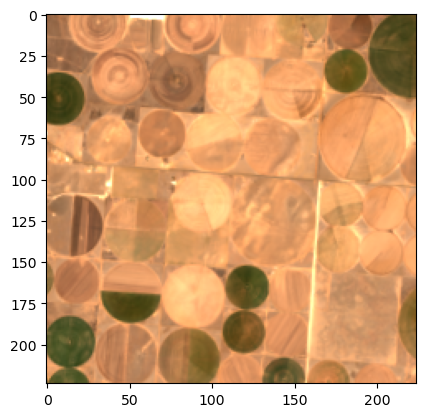

Top left coordinates (image CRS): (-568575.0, 1445565.0)
Bottom right coordinates (image CRS): (-561825.0, 1438815.0)
Top left coordinates (longitude, latitude): (-102.35983111053801, 35.89100745138819)
Bottom right coordinates (longitude, latitude): (-102.27956787008041, 35.83486329580573)
Center coordinates (longitude, latitude): (-102.3196994903092, 35.86293537359696)
Google Map (for validation): https://www.google.com/maps/@35.86293537359696,-102.3196994903092,14z/data=!3m1!1e3


((-102.35983111053801, 35.89100745138819),
 (-102.27956787008041, 35.83486329580573))

In [7]:
from data_utils import plot_tif_rgb, get_tif_lonlat

example_chip = "chip_257_266"
print(f"Example chip: {example_chip}")

plot_tif_rgb(f"./all_chips/{example_chip}_merged.tif")
get_tif_lonlat(f"./all_chips/{example_chip}.mask.tif", debug=True)